In [1]:
import os
import pickle

import pandas as pd
import numpy as np

from pathlib import Path

import chart_studio.plotly as py
import plotly.graph_objects as go
import plotly.express as px

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

import matplotlib.pyplot as plt


# import matplotlib.pyplot as plt

In [2]:
model_base_path = "/data/models/precipitation"

In [3]:
! pip install chart-studio plotly plotly-geo
# ! pip install plotly
# ! pip uninstall -y chart-studio plotly
# !pip install plotly==3.10.0

In [4]:
!ls /data/stations

benque_prec.csv			 hawkesworth_bridge_wtlv_min.csv
central_farm_prec.csv		 santa_elena_prec.csv
chaa_creek_prec.csv		 santa_elena_wtlv1.csv
hawkesworth_bridge_prec.csv	 santa_elena_wtlv_max.csv
hawkesworth_bridge_wtlv1.csv	 santa_elena_wtlv_min.csv
hawkesworth_bridge_wtlv_max.csv


In [5]:
df_all = None
for f in Path('/data/stations').rglob('*_prec*.csv'):
    
    if "benque" in str(f):
        continue
    
    station = os.path.basename(f).split('_prec')[0]
    print(station)
    _df = pd.read_csv(f, parse_dates=["datetime", "updated_at"])
    _df['station'] = station
    if df_all is None:
        df_all = _df
    else:
        df_all = pd.concat([df_all, _df], ignore_index=True)

central_farm
chaa_creek
hawkesworth_bridge
santa_elena


In [6]:
df_all.drop(columns=['updated_at', 'variable_id'], inplace=True)

In [7]:
df_all.head()

datetime  measured  station_id       station
0 2020-04-19 02:00:00+00:00       0.0         169  central_farm
1 2020-04-19 02:05:00+00:00       0.0         169  central_farm
2 2020-04-19 02:10:00+00:00       0.0         169  central_farm
3 2020-04-19 02:15:00+00:00       0.0         169  central_farm
4 2020-04-19 02:20:00+00:00       0.0         169  central_farm

In [8]:
df_day = df_all.groupby([pd.Grouper(key="datetime", freq="2h"), "station", "station_id"]).sum()

In [9]:
df_day.head()

measured
datetime                  station      station_id          
2020-04-19 00:00:00+00:00 central_farm 169              0.0
2020-04-19 02:00:00+00:00 central_farm 169              0.0
2020-04-19 04:00:00+00:00 central_farm 169              0.0
2020-04-19 06:00:00+00:00 central_farm 169              0.0
2020-04-19 08:00:00+00:00 central_farm 169              0.0

In [10]:
df_day.reset_index(inplace=True)

In [11]:
fig = px.bar(df_day, 
             x="datetime", 
             y='measured', 
             color='station',
             barmode='group',
             title='Time Series with Range Slider and Selectors')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=7, label="7d", step="day", stepmode="backward"),
            dict(count=10, label="10d", step="day", stepmode="backward"),
            dict(count=14, label="14d", step="day", stepmode="backward"),            
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

In [12]:
df_day.groupby(['station']).agg({'datetime':[np.min, np.max]})

datetime                          
                                        amin                      amax
station                                                               
central_farm       2020-04-19 00:00:00+00:00 2020-11-30 10:00:00+00:00
chaa_creek         2020-05-04 06:00:00+00:00 2020-11-30 10:00:00+00:00
hawkesworth_bridge 2020-06-24 22:00:00+00:00 2020-11-30 10:00:00+00:00
santa_elena        2020-06-26 22:00:00+00:00 2020-11-30 10:00:00+00:00

In [13]:
data = df_day[['station', 'measured', 'datetime']].pivot(index='datetime', columns='station', values='measured')

In [14]:
data.columns

Index(['central_farm', 'chaa_creek', 'hawkesworth_bridge', 'santa_elena'], dtype='object', name='station')

In [15]:
# remove benque because it has some many bad data
# data = data.drop(columns=['benque'])

In [16]:
# dropna 

print(f"data before dropna: shape={data.shape}")
data.dropna(inplace=True)
print(f"data after  dropna: shape={data.shape}")

# 24h
# data before dropna: shape=(226, 4)
# data after  dropna: shape=(158, 4)

# 6h
# data before dropna: shape=(902, 4)
# data after  dropna: shape=(627, 4)

data before dropna: shape=(2706, 4)
data after  dropna: shape=(1879, 4)


In [17]:
data.sort_index(inplace=True)

In [18]:
data

station                    central_farm  chaa_creek  hawkesworth_bridge  \
datetime                                                                  
2020-06-26 22:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 00:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 02:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 04:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 06:00:00+00:00           0.0         0.0                 0.0   
...                                 ...         ...                 ...   
2020-11-30 02:00:00+00:00           0.0         0.0                 0.0   
2020-11-30 04:00:00+00:00           0.0         0.0                 0.0   
2020-11-30 06:00:00+00:00           0.0         0.0                 0.0   
2020-11-30 08:00:00+00:00           0.0         0.0                 0.0   
2020-11-30 10:00:00+00:00           0.0         0.0                 0.0   

station                    santa_elena  
datetime                                
2020-06-26 22:00:00+00:00          0.0  
2020-06-27 00:00:00+00:00          0.0  
2020-06-27 02:00:00+00:00          0.0  
2020-06-27 04:00:00+00:00          0.0  
2020-06-27 06:00:00+00:00          0.0  
...                                ...  
2020-11-30 02:00:00+00:00          0.0  
2020-11-30 04:00:00+00:00          0.0  
2020-11-30 06:00:00+00:00          0.0  
2020-11-30 08:00:00+00:00          0.0  
2020-11-30 10:00:00+00:00          0.0  

[1879 rows x 4 columns]

In [19]:
fig = go.Figure(data=[
#     go.Bar(name='avg', x=data.index, y=data.avg),
#     go.Bar(name='santa_elena', x=data.index, y=data.santa_elena, text=data.label),
    go.Bar(name='santa_elena', x=data.index, y=data.santa_elena),
    go.Bar(name='central_farm', x=data.index, y=data.central_farm),
    go.Bar(name='hawkesworth_bridge', x=data.index, y=data.hawkesworth_bridge),
    go.Bar(name='chaa_creek', x=data.index, y=data.chaa_creek)
])

# Change the bar mode
fig.update_layout(barmode='group')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1d", step="day", stepmode="backward"),
            dict(count=7, label="7d", step="day", stepmode="backward"),
            dict(count=10, label="10d", step="day", stepmode="backward"),
            dict(count=14, label="14d", step="day", stepmode="backward"),            
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

fig.show()

In [20]:
def split_df(df, x_columns, y_column, day):
    
    df = df.reset_index()
    
    df_slice = df[df.datetime.dt.date < day] 
    X_train = df_slice[x_columns]
    y_train = df_slice[y_column]
    
    df_slice = df[df.datetime.dt.date >= day] 
    X_test = df_slice[x_columns]
    y_test = df_slice[y_column]
    
    print(f"X_train={X_train.shape}, X_test={X_test.shape}, y_train={y_train.shape}, y_test={y_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [21]:
def create_data_classification(df, columns, target, threshold):
    
    columns = columns[columns != target]
    
    df['avg'] = df[columns].mean(axis=1) 
    
    df.loc[df[target] >  df['avg'] * (1 + threshold), 'label'] = 0
    df.loc[df[target] <= df['avg'] * (1 + threshold), 'label'] = 1
    
    df = df.astype({'label': np.int})
    
    print(df.head())
    return df
    
    
data = create_data_classification(data, np.array(['hawkesworth_bridge']), 'santa_elena', 0.3)

station                    central_farm  chaa_creek  hawkesworth_bridge  \
datetime                                                                  
2020-06-26 22:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 00:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 02:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 04:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 06:00:00+00:00           0.0         0.0                 0.0   

station                    santa_elena  avg  label  
datetime                                            
2020-06-26 22:00:00+00:00          0.0  0.0      1  
2020-06-27 00:00:00+00:00          0.0  0.0      1  
2020-06-27 02:00:00+00:00          0.0  0.0      1  
2020-06-27 04:00:00+00:00          0.0  0.0      1  
2020-06-27 06:00:00+00:00          0.0  0.0      1  


In [22]:
data.columns

Index(['central_farm', 'chaa_creek', 'hawkesworth_bridge', 'santa_elena',
       'avg', 'label'],
      dtype='object', name='station')

In [23]:
X_train, X_test, y_train, y_test = split_df(data, 
                                            ['central_farm', 'chaa_creek', 'hawkesworth_bridge', 'santa_elena'],
                                            'label',
                                            datetime(2020, 11, 1).date())

X_train=(1525, 4), X_test=(354, 4), y_train=(1525,), y_test=(354,)


In [24]:
clf = RandomForestClassifier(max_depth=7, n_estimators=250)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [25]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9209039548022598


In [26]:
filename_model = f'{model_base_path}/rf_001.pickle'
model_dir = os.path.dirname(filename_model)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
with open(filename_model, "wb") as f:
    pickle.dump(clf, f)

Confusion matrix, without normalization
[[ 86  19]
 [  9 240]]
Normalized confusion matrix
[[0.81904762 0.18095238]
 [0.03614458 0.96385542]]


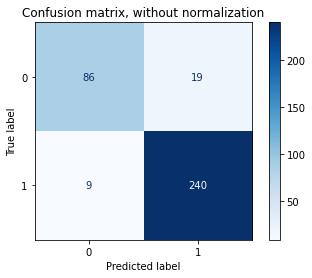

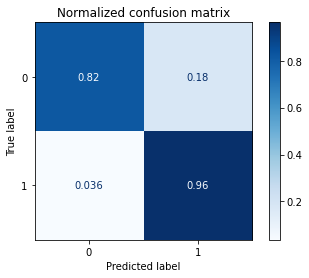

In [27]:


class_names = [0, 1]

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

In [28]:
# busca em grade 
# profundidade 3 - 10
# numero de estimadores 50 a 500

# gráfico com intervalo de 1h a 24h

# importancia das características


# plotar árvore da busca

## Grid Search

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
parameters = [{
    'max_depth': list(range(3,11)),
    'n_estimators': list(range(50, 501, 50))
}]

In [31]:
parameters

[{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
  'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}]

In [32]:
clf = GridSearchCV(
        RandomForestClassifier(), parameters, scoring='accuracy'
    )
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                          'n_estimators': [50, 100, 150, 200, 250, 300, 350,
                                           400, 450, 500]}],
             scoring='accuracy')

In [33]:
print(clf.best_params_)

{'max_depth': 10, 'n_estimators': 50}


## Find best aggregation interval

In [34]:
# [10, 20, 30, 40, 50, 60, 120, 180, 240, 300, 360, 420, 480, 540, 600, 660, 720, 780, 840, 900, 960, 1020, 1080, 1140, 1200, 1260, 1320, 1380, 1440]
minutes = list(range(5, 60, 10))
minutes.extend(list(range(60, 24* 60 + 1, 60)))


results = []
for m in minutes:
    print(f"\n\nMinute: {m}")
    df_day = df_all.groupby([pd.Grouper(key="datetime", freq=f"{m}min"), "station", "station_id"]).sum()
    
    df_day.reset_index(inplace=True)
    
    data = df_day[['station', 'measured', 'datetime']].pivot(index='datetime', columns='station', values='measured')

    print(f"data before dropna: shape={data.shape}")
    data.dropna(inplace=True)
    print(f"data after  dropna: shape={data.shape}")

    data = create_data_classification(data, np.array(['hawkesworth_bridge']), 'santa_elena', 0.3)

    X_train, X_test, y_train, y_test = split_df(data, 
                                            ['central_farm', 'chaa_creek', 'hawkesworth_bridge', 'santa_elena'],
                                            'label',
                                            datetime(2020, 11, 1).date())
    
    clf = RandomForestClassifier(max_depth=7, n_estimators=250)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    
    # Model Accuracy, how often is the classifier correct?
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy, "\n")
    results.append((m, accuracy))
    
    




Minute: 5
data before dropna: shape=(64860, 4)
data after  dropna: shape=(44819, 4)
station                    central_farm  chaa_creek  hawkesworth_bridge  \
datetime                                                                  
2020-06-26 22:35:00+00:00           0.0         0.0                 0.0   
2020-06-26 22:40:00+00:00           0.0         0.0                 0.0   
2020-06-26 22:45:00+00:00           0.0         0.0                 0.0   
2020-06-26 22:50:00+00:00           0.0         0.0                 0.0   
2020-06-26 22:55:00+00:00           0.0         0.0                 0.0   

station                    santa_elena  avg  label  
datetime                                            
2020-06-26 22:35:00+00:00          0.0  0.0      1  
2020-06-26 22:40:00+00:00          0.0  0.0      1  
2020-06-26 22:45:00+00:00          0.0  0.0      1  
2020-06-26 22:50:00+00:00          0.0  0.0      1  
2020-06-26 22:55:00+00:00          0.0  0.0      1  
X_train=(36387, 4

Accuracy:  0.903954802259887 



Minute: 180
data before dropna: shape=(1804, 4)
data after  dropna: shape=(1253, 4)
station                    central_farm  chaa_creek  hawkesworth_bridge  \
datetime                                                                  
2020-06-26 21:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 00:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 03:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 06:00:00+00:00           0.0         0.0                 0.0   
2020-06-27 09:00:00+00:00           7.2         0.2                 3.0   

station                    santa_elena  avg  label  
datetime                                            
2020-06-26 21:00:00+00:00        0.000  0.0      1  
2020-06-27 00:00:00+00:00        0.000  0.0      1  
2020-06-27 03:00:00+00:00        0.000  0.0      1  
2020-06-27 06:00:00+00:00        0.000  0.0      1  
2020-06-27 09:00:00+00:00        4.064 

Accuracy:  0.8450704225352113 



Minute: 660
data before dropna: shape=(492, 4)
data after  dropna: shape=(342, 4)
station                    central_farm  chaa_creek  hawkesworth_bridge  \
datetime                                                                  
2020-06-26 18:00:00+00:00           0.2         0.0                 0.0   
2020-06-27 05:00:00+00:00           7.4         0.2                 3.2   
2020-06-27 16:00:00+00:00           0.0         0.0                 0.0   
2020-06-28 03:00:00+00:00           0.0         0.0                 0.0   
2020-06-28 14:00:00+00:00           0.0         1.4                 0.0   

station                    santa_elena  avg  label  
datetime                                            
2020-06-26 18:00:00+00:00        0.000  0.0      1  
2020-06-27 05:00:00+00:00        4.064  3.2      1  
2020-06-27 16:00:00+00:00        0.508  0.0      0  
2020-06-28 03:00:00+00:00        0.000  0.0      1  
2020-06-28 14:00:00+00:00        0.000  

Accuracy:  0.8205128205128205 



Minute: 1140
data before dropna: shape=(285, 4)
data after  dropna: shape=(198, 4)
station                    central_farm  chaa_creek  hawkesworth_bridge  \
datetime                                                                  
2020-06-26 21:00:00+00:00           7.4         0.2                 3.2   
2020-06-27 16:00:00+00:00           0.0         0.0                 0.0   
2020-06-28 11:00:00+00:00           0.0         1.4                 0.0   
2020-06-29 06:00:00+00:00           1.2         0.0                 0.0   
2020-06-30 01:00:00+00:00           5.2         2.2                 1.0   

station                    santa_elena  avg  label  
datetime                                            
2020-06-26 21:00:00+00:00        4.064  3.2      1  
2020-06-27 16:00:00+00:00        0.508  0.0      0  
2020-06-28 11:00:00+00:00        0.000  0.0      1  
2020-06-29 06:00:00+00:00        0.000  0.0      1  
2020-06-30 01:00:00+00:00        6.096 

In [35]:
df_result = pd.DataFrame(data=results, columns=['minute', 'accuracy'])

In [36]:
df_result.dtypes

minute        int64
accuracy    float64
dtype: object

In [37]:
import plotly.express as px
fig = px.line(df_result, x="minute", y="accuracy", title='Interval Accuracy')
fig.show()

In [38]:
from sklearn.inspection import permutation_importance

X_val = data[['central_farm', 'chaa_creek', 'hawkesworth_bridge', 'santa_elena']]
y_val = data['label']
r = permutation_importance(clf, 
                           X_val, 
                           y_val,
                           n_repeats=30,
                           random_state=0)

In [39]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_val.columns[i]:<8} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

santa_elena 0.399 +/- 0.028
hawkesworth_bridge 0.180 +/- 0.023
chaa_creek 0.107 +/- 0.021


In [41]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(clf.estimators_[0], 
                out_file='tree-santa-elenena-high-values.dot', 
                feature_names=X_val.columns,
                class_names=['0', '1'],
                # rounded = True, 
                # proportion = False, 
                # precision = 2, 
                filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree-santa-elenena-high-values.dot', '-o', 'tree-santa-elenena-high-values.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree-santa-elenena-high-values.png')

In [43]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Feature ranking:


NameError: name 'X' is not defined

In [ ]:
# árvore 4 níveis

# fazer gráfico com acurácia 10% dos dados até 50% dos dados

# dadod do IMERGE